This spatial analysis investigates whether eviction rates are higher in census tracts located near future Purple Line light rail stations in Prince George’s and Montgomery Counties, Maryland. As the Purple Line continues construction, there is growing concern that new transit infrastructure could trigger housing displacement and instability in surrounding communities. This study explores whether these patterns are already observable in eviction data.

To answer this question, I calculated eviction rates per 1,000 renter households using warrant-level eviction filings and tract-level housing tenure data from the 2023 American Community Survey. I flagged census tracts as “near” if they intersected a 1-mile buffer around planned Purple Line stations. A boxplot comparison and choropleth map were used to evaluate spatial differences in eviction intensity between “near” and “not near” tracts.

The analysis reveals that eviction rates are not currently concentrated near Purple Line stations. In fact, the highest eviction rates appear in tracts located farther away, particularly in southern Prince George’s County and parts of northwest Montgomery County. Tracts near stations tended to have lower and more consistent eviction rates. This could suggest that the Purple Line has not yet created significant housing market pressure due to its unfinished status. Alternatively, it could challenge the assumption that new transit investments inherently increase eviction risk, pointing instead to broader structural patterns of housing insecurity.

Overall, the findings highlight the value of using spatial data to inform discussions of equitable transit development. Continued monitoring of eviction patterns post-construction will be essential to understanding the Purple Line’s long-term social impact.

In [1]:
import pandas as pd
import geopandas as gpd
import utils
import exercise03
import census_geocode

%load_ext autoreload
%autoreload 2

In [2]:
# Load warrants and make sure zip codes are stored as strings without decimals
warrants_df = pd.read_csv('md_eviction_warrents_through_2024.csv')
warrants_df['TenantZipCode'] = warrants_df['TenantZipCode'].astype('Int64').astype('string')
len(warrants_df) # How many warrants are we working with?

411040

In [3]:
# Rather than geocoding 400K+ addresses, could we get only the unique ones?
geocode_input_df = exercise03.prep_warrants_for_geocoding(warrants_df)

411040 warrants input
Reduced to 167949 unique addresses


In [4]:
# The Census Geocoder API can only accept up to 10K rows at a time, so we have to break
# our dataframe into chunks

# Split into dataframes with less than 10K rows each
geocode_input_dfs = utils.chunk_dataframe(geocode_input_df, 9999)

# Save each dataframe as a CSV without a header
utils.save_dfs_to_csv(geocode_input_dfs, 'geocode_inputs', header=False)

split dataframe into 17 chunks


In [5]:
# Geocode addresses with the Census Geocoder (set test=True to process only one file)
census_geocode.geocode_csvs('geocode_inputs', 'geocode_outputs', test=True)

TEST MODE: Processing only one file.
Processing file: geocode_inputs/df_14.csv
Saved results to: geocode_outputs/geocoderesult_df_14.csv


In [6]:
# Recombine outputs from geocoder into a single dataframe
geocode_output_df = exercise03.combine_census_geocoded_csvs('geocode_outputs')
len(geocode_output_df)

9999

In [7]:
# Merge geocoded address back onto the inputs with separate fields for address, city, state, and zip
geocoded_df = geocode_input_df.merge(geocode_output_df, left_index=True, right_index=True)
len(geocoded_df)

9999

In [8]:
# Use address, city, state, and zip columns to join geocodes onto original warrant records
warrants_df = warrants_df.merge(geocoded_df, on=['TenantAddress','TenantCity','TenantState','TenantZipCode'])
len(warrants_df)

15112

In [9]:
# Convert warrants into a geodataframe with points
warrants_gdf = utils.lonlat_str_to_geodataframe(warrants_df, 'match_lon_lat')

In [10]:
# What proportion of records have points?
len(warrants_gdf[warrants_gdf.lon.notnull()]) / len(warrants_gdf)

0.948782424563261

In [11]:
# What proportion of records have exact geocode matches?
len(warrants_gdf[warrants_gdf.match_type == 'Exact']) / len(warrants_gdf)

0.5974060349391213

In [12]:
!pip install pyarrow
warrants_gdf.to_parquet('md_eviction_warrants_through_2024.geoparquet')

In [13]:
gdf = gpd.read_parquet('md_eviction_warrants_through_2024.geoparquet')

In [14]:
gdf.columns.tolist()

['ID',
 'EventDate',
 'EventType',
 'EventComment',
 'County',
 'Location',
 'TenantAddress',
 'TenantCity',
 'TenantState',
 'TenantZipCode',
 'CaseType',
 'CaseNumber',
 'EvictedDate',
 'Source',
 'SourceDate',
 'Year',
 'EvictionYear',
 'unique_id',
 'input_address',
 'match_status',
 'match_type',
 'match_address',
 'match_lon_lat',
 'match_tiger_line_id',
 'match_tiger_line_side',
 'lon',
 'lat',
 'geometry']

In [15]:
#0: Filter eviction cases to only those in PG and Montgomery Counties
# Normalize County column for matching
warrants_gdf['County'] = warrants_gdf['County'].str.lower().str.strip()

# Filter for Prince George's and Montgomery counties
pg_mo_evictions = warrants_gdf[
    warrants_gdf['County'].str.contains("prince george") |
    warrants_gdf['County'].str.contains("montgomery")
].copy()

In [16]:
#1: Load Purple Line station data
purple_line_stations = gpd.read_file('Purple_Line_stations/Purple_Line_stattions.shp')

In [17]:
#2: Create a 1-mile buffer around each station to define “near” area

# Reproject to a projected CRS for Maryland
buffers = purple_line_stations.to_crs(epsg=2248)

# Buffer 1 mile (1,609.34 meters)
buffers['geometry'] = buffers.buffer(1609.34)

In [18]:
#3: Spatial join - is eviction inside buffer?
pg_mo_evictions = pg_mo_evictions.to_crs(epsg=2248)
joined = pg_mo_evictions.sjoin(buffers, how='left', predicate='within')
joined['near_pl_station'] = joined['index_right'].notnull()
pg_mo_evictions = joined.drop(columns=['index_right'])

In [19]:
#4: Compare eviction rates
near_pct = pg_mo_evictions['near_pl_station'].mean()
print(f"Eviction filings near Purple Line stations: {near_pct:.2%}")
print(f"Eviction filings elsewhere: {(1 - near_pct):.2%}")

Eviction filings near Purple Line stations: 1.25%
Eviction filings elsewhere: 98.75%


This doesn't really get at the question I was really trying to ask. Below is additional analysis that tries to answer the following question: Are eviction rates higher in census tracts that intersect a 1-mile buffer around Purple Line stations compared to those that don’t?

In [20]:
pip install censusdis geopandas pyarrow

Note: you may need to restart the kernel to use updated packages.


In [72]:
#1: Pull tracts + renter data from ACS
tracts = gpd.read_file("tl_2023_24_tract/tl_2023_24_tract.shp")
tracts = tracts.to_crs(epsg=2248)  # Project for spatial ops

tracts = tracts[tracts['COUNTYFP'].isin(['031', '033'])].copy()
tracts['GEOID'] = tracts['GEOID'].astype(str)

renter_data = pd.read_csv("acs2023_5yr_B25003_14000US24037876102/acs2023_5yr_B25003_14000US24037876102.csv")

# Rename and keep only housing units and renter occupied units
renter_data = renter_data.rename(columns={
    'geoid': 'GEOID',
    'B25003001': 'total_housing_units',
    'B25003003': 'renter_occupied_units'
})

# Ensure GEOID format matches
renter_data['GEOID'] = renter_data['GEOID'].astype(str).str.zfill(11)

renter_data['GEOID'] = renter_data['GEOID'].str[-11:]

# Merge with tract shapes
tracts = tracts.merge(renter_data[['GEOID', 'total_housing_units', 'renter_occupied_units']], on='GEOID', how='left')

#Calculate % Renter Rate
tracts['pct_renter'] = tracts['renter_occupied_units'] / tracts['total_housing_units']
tracts['renter_occupied_units'] = tracts['renter_occupied_units'].fillna(0)

In [73]:
#2: Create 1-mile buffers
purple_line_stations = gpd.read_file('Purple_Line_stations/Purple_Line_stattions.shp')
buffers = purple_line_stations.to_crs(epsg=2248)
buffers['geometry'] = buffers.buffer(1609.34)

In [74]:
#3: Flag tracts that intersect with buffer
tracts['near_pl_station'] = tracts.intersects(buffers.geometry.unary_union)

/var/folders/f7/vk15qg0n2fxcmz0j1f6v78t80000gn/T/ipykernel_35706/234538959.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  tracts['near_pl_station'] = tracts.intersects(buffers.geometry.unary_union)


In [75]:
#4: Spatial join: assign evictions to tracts
# Make sure evictions are projected correctly
pg_mo_evictions = pg_mo_evictions.to_crs(epsg=2248)

# Spatial join: which tract each eviction falls in
evictions_with_tracts = gpd.sjoin(pg_mo_evictions, tracts, how='left', predicate='within')

# Count evictions per tract
eviction_counts = evictions_with_tracts.groupby('GEOID').size().reset_index(name='eviction_count')

# Merge back into tract GeoDataFrame
tracts = tracts.drop(columns=['eviction_count'], errors='ignore')

tracts = tracts.merge(eviction_counts, on='GEOID', how='left')
tracts['eviction_count'] = tracts['eviction_count'].fillna(0)

# Calculate eviction rate per 1,000 renter households
tracts['eviction_rate_per_1k_renters'] = (tracts['eviction_count'] / tracts['renter_occupied_units']) * 1000

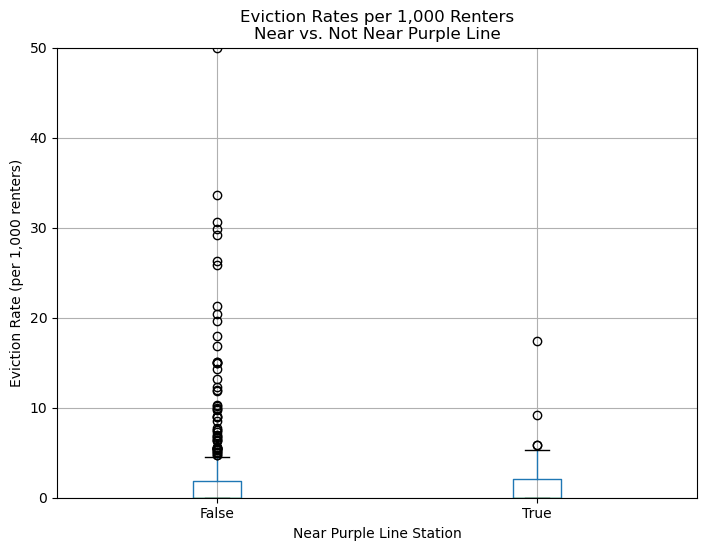

In [79]:
#5: Boxplot comparing eviction rates by proximity
import matplotlib.pyplot as plt

tracts_clean = tracts[
    tracts['eviction_rate_per_1k_renters'].notnull() &
    tracts['near_pl_station'].notnull()
]

tracts_clean.boxplot(
    column='eviction_rate_per_1k_renters',
    by='near_pl_station',
    figsize=(8, 6)
)
plt.title('Eviction Rates per 1,000 Renters\nNear vs. Not Near Purple Line')
plt.suptitle('')
plt.xlabel('Near Purple Line Station')
plt.ylabel('Eviction Rate (per 1,000 renters)')
plt.ylim(0, 50)  #limit Y axis to better see the main distribution
plt.show()

/var/folders/f7/vk15qg0n2fxcmz0j1f6v78t80000gn/T/ipykernel_35706/4071880187.py:40: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


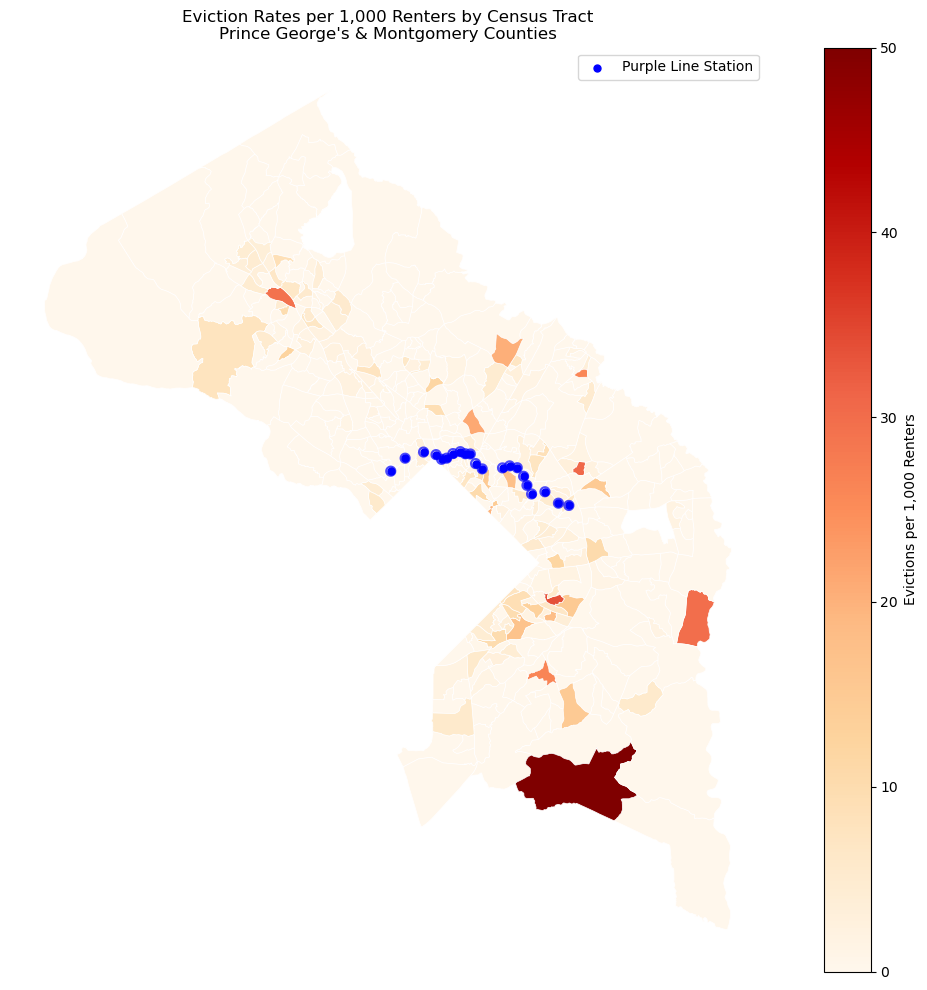

In [84]:
#6: Map eviction rates
# Filter out extreme outliers for visualization (like before)
tracts_map = tracts[tracts['eviction_rate_per_1k_renters'] < 100].copy()

# Set up figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot census tracts shaded by eviction rate
tracts_map.plot(
    column='eviction_rate_per_1k_renters',
    cmap='OrRd',
    linewidth=0.5,
    ax=ax,
    edgecolor='white',
    legend=True,
    legend_kwds={'label': "Evictions per 1,000 Renters"}
)

# Overlay 1-mile buffers
buffers.plot(
    ax=ax,
    facecolor='none',
    edgecolor='blue',
    linewidth=1.5,
    alpha=0.7,
    label='1-Mile Buffer'
)

# Overlay station points
purple_line_stations.to_crs(tracts.crs).plot(
    ax=ax,
    color='blue',
    markersize=25,
    label='Purple Line Station'
)

# Styling
plt.title('Eviction Rates per 1,000 Renters by Census Tract\nPrince George\'s & Montgomery Counties')
plt.axis('off')
plt.legend()
plt.tight_layout()
plt.show()